# **Importaciónes generales**
**Importamos paquetes necesarios y los datos de Fashion MNIST, tambien se definen algunas funciones básicas del plot de imágenes y la de rounded accuracy para las métricas**

In [38]:
import sklearn
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd


# Seed para que las redes con iguales parametros no generen resultados aleatorios y tener repetibilidad
np.random.seed(42)
tf.random.set_seed(42)

# Para las graficas
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

#Función para plotear
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

#Función Rounded Accuracy
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

    
#Traemos los datos de Fashion MNIST
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full_normalized = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full_normalized[:-5000], X_train_full_normalized[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

#Función para ver los resultados de las reconstrucciones
def show_reconstructions(model, images=X_test, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])
        
#Función para ver los resultados de las reconstrucciones en el modelo con 2 salidas
def show_reconstructions_class(model, images=X_test, n_images=5):
    reconstructions,_ = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])
        
#Función para visualziar multiples imagenes generadas por las GANs o VAEs        
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

# **Sección 2.2**

2.2.1 Autoencoder regularizado usando convolucionales

**Definición y entrenamiento**

In [ ]:
#Seed para evitar el factor aleatorio
tf.random.set_seed(42)
np.random.seed(42)
#Early stop por si es necesario
#Early_stop=keras.callbacks.EarlyStopping(monitor='loss',min_delta=0.0001,patience=3,verbose=1,restore_best_weights=True,start_from_epoch=150)
batch=64

#Definicion del encoder con convolucionales 
conv_encoder = keras.models.Sequential([
    keras.layers.Input(shape=[28, 28]),
    keras.layers.Reshape([28, 28, 1]),
    keras.layers.Conv2D(16, kernel_size=3, padding="SAME", activation="relu",kernel_initializer="HeNormal",kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dropout(rate=0.1),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size=3, padding="SAME", activation="relu",kernel_initializer="HeNormal",kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dropout(rate=0.1),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64, kernel_size=3, padding="SAME", activation="relu",kernel_initializer="HeNormal",kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dropout(rate=0.1),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Dense(128,activation="relu")
])
conv_encoder.summary()
#Definición del decoder con convolucionales
conv_decoder = keras.models.Sequential([
    keras.layers.Input(shape=[3, 3, 128]),
    keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="VALID", activation="relu",kernel_initializer="HeNormal",kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dropout(rate=0.1),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding="SAME", activation="relu",kernel_initializer="HeNormal",kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dropout(rate=0.1),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding="SAME", activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

#Definicion del autoencoder combinando el enconder y decoder ya definidos
conv_ae = keras.models.Sequential([conv_encoder, conv_decoder])

#Se compila y entrena el modelo
conv_ae.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=0.0001),
                metrics=[rounded_accuracy])

#Clear session para evitar que se guarde el entrenamiento por cada corrida del codigo
keras.backend.clear_session()
history = conv_ae.fit(X_train, X_train, batch,epochs=300,
                      validation_data=(X_valid, X_valid))#,callbacks=[Early_stop])


**Evolución del loss y accuracy**

In [ ]:
#Graficamos el loss de entrenamiento y de validación

plt.plot(history.history["loss"],label="Loss")
plt.plot(history.history["val_loss"],label="Val_loss")
plt.grid(True)
#plt.xlim(0,20)
plt.ylim(0,0.05)
plt.legend()
plt.show()

In [ ]:
#Graficamos el accuracy de entrenamiento y el de validación

plt.plot(history.history["rounded_accuracy"],label="Accuracy")
plt.plot(history.history["val_rounded_accuracy"],label="Val_Accuracy")
plt.grid(True)
#plt.xlim(0,20)
plt.ylim(0.7,0.97)
plt.legend()
plt.show()

**Predicción y Visualización de resultados**

In [ ]:
#Usando la función definida se hace una predicción y se visualiza

show_reconstructions(conv_ae)
plt.show()

**Discusión**

* Los valores y convergencia del loss y accuracy son bastante satisfactorios, lo que se puede observar bien en las imagenes de la reconstrucción comparadas con las originales.

* La elección de la función de perdida es reelevate, mse funciona mejor que binary cross entropy en este caso ya que las reconstrucciones son directas, diferente al caso del modelo variacional donde las reconstruciones se hacen con densidades de probabildad en el espacio latente.

* Las gráficas de evolución del loss y accuracy muestran pocas fluctuaciones y una buena tendencia a la convergencia, lo que me lleva a resaltar una buena elección del optimizador y el learning rate.

* Tambíen probé con el pooling, cambiando de maxpooling a averagepooling, pero el resultado fue mejor en maxpooling, asi que en este caso favorece más el valor máximo que el promedio.

* Parámetros como el stride o el kernel size tambien pueden modificarse pero son más limitados por el tamaño requerido de las imagenes en el output, trate de modificarlo pero el mejor resultado fue siempre con kernel=3 y stride=2, cambiarlos dejando el mismo tamaño de output solo empeora el resultado de salida.

* Respecto a los tips de entrenamiento se pueden resaltar varias cosas:

    1. Si ubiera seguido con el optimizador SGD se podian ver resultados aceptables casi sin emplear ningún tip, y tampoco daba señales de overfitting, pero al cambiar a Adam los resultados sin emplear tips de entrenamiento eran muy malos, y SGD requeria un learning rate muy alto para converger a un resultado aceptable en menos de 300 epocas, tardando demasiado en la ejecución.
    2. Utilizando inicializadores y batch normalization Adam ya llegaba a algo, aunque seguia lejos de ser bueno, al menos se podía ver algun resultado de la predición, con mucho loss y poco accuracy.
    3. Ajustando el learning rate a un número inferior a 0.01, y utilizando regularizadores y dropout, pude darle 300 epocas a Adam para lograr el resultado final sin riesgo de overfitting. Lo más importante de esto fue el learning rate, con SGD un learning rate de 0.001 necesitaria unas 500 epocas para llegar al resultado que alcanzo Adam, pero sin los regularizadores ni el dropout el resulado no era bueno y corría riesgo de overfitting.
 
* Al final, con un loss de menos de 0.009 y un accuracy de más de 0.95, quedo conforme con el resultado del entrenamiento de la red.


2.2.2 Autoencoder Variacional

**Definición y Entrenamiento**

In [ ]:
#Definimos la función que crea el encoder
def build_encoder(latent_dim):
    encoder_inputs = tf.keras.layers.Input(shape=(28, 28, 1))
    x = tf.keras.layers.Conv2D(8, 3, activation='relu', strides=2, padding='same',kernel_initializer="HeNormal",kernel_regularizer=keras.regularizers.l1l2(l1=0.02,l2=0.02))(encoder_inputs)
    x = tf.keras.layers.Dropout(0.4)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(16, 3, activation='relu', strides=2, padding='same',kernel_initializer="HeNormal",kernel_regularizer=keras.regularizers.l1l2(l1=0.02,l2=0.02))(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(32, 3, activation='relu', strides=2, padding='same',kernel_initializer="HeNormal",kernel_regularizer=keras.regularizers.l1l2(l1=0.02,l2=0.02))(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(64, 3, activation='relu', strides=2, padding="same",kernel_initializer="HeNormal",kernel_regularizer=keras.regularizers.l1l2(l1=0.02,l2=0.02))(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(128, 3, activation='relu', strides=2, padding="same",kernel_initializer="HeNormal",kernel_regularizer=keras.regularizers.l1l2(l1=0.02,l2=0.02))(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(20, activation='relu',kernel_initializer="HeNormal",kernel_regularizer=keras.regularizers.l2(0.1))(x)
    x = tf.keras.layers.BatchNormalization()(x)
#En lugar de tener una sola salida, el encoder tiene como salidas los valores necesarios para calcular la densidad de probabilidad
#en la nube del espacio latente
    z_mean = tf.keras.layers.Dense(latent_dim,activation="sigmoid")(x)
    z_log_var = tf.keras.layers.Dense(latent_dim,activation="sigmoid")(x)
    encoder = tf.keras.Model(encoder_inputs, [z_mean, z_log_var], name='encoder')
    return encoder

#Definimos la función que crea el decoder
def build_decoder(latent_dim):
    decoder_inputs = tf.keras.layers.Input(shape=(latent_dim,))
    x = tf.keras.layers.Dense(150, activation='relu',kernel_initializer="HeNormal",kernel_regularizer=keras.regularizers.l1l2(l1=0.02,l2=0.02))(decoder_inputs)
    x = tf.keras.layers.Dropout(0.4)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(7*7*64, activation='relu',kernel_initializer="HeNormal",kernel_regularizer=keras.regularizers.l1l2(l1=0.02,l2=0.02))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Reshape((7, 7, 64))(x)
    x = tf.keras.layers.Conv2DTranspose(128, 3, activation='relu', strides=2, padding='same',kernel_initializer="HeNormal",kernel_regularizer=keras.regularizers.l1l2(l1=0.02,l2=0.02))(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPool2D(pool_size=2)(x)
    x = tf.keras.layers.Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same',kernel_initializer="HeNormal",kernel_regularizer=keras.regularizers.l1l2(l1=0.02,l2=0.02))(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same',kernel_initializer="HeNormal",kernel_regularizer=keras.regularizers.l1l2(l1=0.02,l2=0.02))(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2DTranspose(16, 3, activation='relu', strides=2, padding='same',kernel_initializer="HeNormal",kernel_regularizer=keras.regularizers.l1l2(l1=0.02,l2=0.02))(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPool2D(pool_size=2)(x)
    decoder_outputs = tf.keras.layers.Conv2DTranspose(1, 3, activation='sigmoid', padding='same')(x)
    decoder = tf.keras.Model(decoder_inputs, decoder_outputs, name='decoder')
    return decoder

#Esta clase se crea para introducir las propiedades del autoencode variacional, en particular el loss probabilistico
class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
#La funcion call de la clase VAE calcula el loss por divergencia Kl usando los datos de salida del encoder, y luego los añade
#usado el metrodo add_loss
    def call(self, inputs):
        z_mean, z_log_var = self.encoder(inputs)
        z = self.reparameterize(z_mean, z_log_var)
        reconstructed = self.decoder(z)
        kl_loss = -0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
        self.add_loss(kl_loss)
        return reconstructed
#Esta funcion se usa en la función call para convertir las muestras del espacio latente en un conjunto continuo y diferenciable, y asi 
#el espacio latente se convierte en la nube de probabilidad
    def reparameterize(self, z_mean, z_log_var):
        eps = tf.random.normal(shape=tf.shape(z_mean))
        return eps * tf.exp(z_log_var * .5) + z_mean

In [ ]:
#Como voy a poner muchas epocas, prefiero definir una funcion para hacer learning rate scheduling
#Define los pasos basado en la epoca
def piecewise_constant(boundaries, values):
    boundaries = np.array([0] + boundaries)
    values = np.array(values)
    def piecewise_constant_fn(epoch):
        return values[np.argmax(boundaries > epoch) - 1]
    return piecewise_constant_fn


In [ ]:
#Luego de definir las funcions y la clase VAE, se crea y entrena el modelo
#Este parametro determina el tamaño del espacio latente, o lo que es lo mismo, el número de neuronas de las últimas capas del encoder
latent_dim = 10
#Llamamos las funciones para crear el encoder y decoder
encoder = build_encoder(latent_dim)
decoder = build_decoder(latent_dim)
#Usamos la clase VAE para definir el modelo
vae = VAE(encoder, decoder)
#Se crea el callback para el learning rate scheduling
piecewise_constant_fn = piecewise_constant([100,200,300], [0.1, 0.01, 0.005,0.001])
#scheduler=keras.callbacks.LearningRateScheduler(piecewise_constant_fn)
#Compilamos y entrenamos
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="binary_crossentropy",metrics=[rounded_accuracy])
#Clear session para no guardar datos de entrenamientos anteriores
keras.backend.clear_session()
history=vae.fit(X_train, X_train, epochs=400, batch_size=64, validation_data=(X_valid, X_valid))#,callbacks=[scheduler])

**Evolución del loss y el accuracy**

In [ ]:
#Graficamos el loss de entrenamiento y validación
plt.plot(history.history["loss"],label="Loss")
plt.plot(history.history["val_loss"],label="Val_loss")
plt.grid(True)
#plt.xlim(0,20)
plt.ylim(0.49,0.52)
plt.legend()
plt.show()

In [ ]:
#Graficamos el accuracy de entrenamiento y el de validación

plt.plot(history.history["rounded_accuracy"],label="Accuracy")
plt.plot(history.history["val_rounded_accuracy"],label="Val_Accuracy")
plt.grid(True)
#plt.xlim(0,20)
plt.ylim(0.7,0.75)
plt.legend()
plt.show()

**Predicción y visualización de resultados**

In [ ]:
show_reconstructions(vae)
plt.show()

**Discusión**
* La función de costo es dferente al modelo regularizado, ya que al funcionar por probabilidaes en este caso es mejor usar binary crossentropy que trabaja mejor con densidades de probabilidad que mse.
* Se mejoró la convergencia de Adam como optimizador usando los diferentes tips de entrenamiento como regularización, dropout y batch normalization, pero la reconstrucción y el loss llegaron a un punto donde sin importar que le mueva a la arquitectura de la red, no cambia ninguno de los 2.

2.2.3 GANs

**Toda esta sección se aloja en un cuaderno aparte con el fin de destinarle todos los recursos de ese cuaderno al ser un modelo tan exigente**

**Discusión**
* Este modelo es increiblemente pesado de ejecutar. Consume tantos recursos que lo máximo que me permite la RAM de kaggle son 10 epocas y tengo que reiniciar l sesión porque la RAM queda llena y no se como vaciarla.
* El problema de ejecutar pocas epocas es que no hay mucho margen para ver la mejora del modelo y los tiempos de ejecución siempre son muy elevados, 

# Sección 2.3
**Clasificación y GradCAM+++**

**Nuevas librerias y funciones necesarias**

In [ ]:
#La primera vez tuve que instalar el paquete de vis, aunque ahora esta configurado para guardarse en el entorno, es mejor dejarlo aqui por si algo
#!pip install tf-keras-vis tensorflow --target=/kaggle/working/

In [39]:
#importamos las librerias de vis par usar GradCAM++
import tf_keras_vis 
from tf_keras_vis.utils import normalize
from tf_keras_vis.utils import num_of_gpus
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore

#importamos la matriz de confuson para ver el resultado de la clasificación
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

#Definimos una función para graficar la matriz de confusion
def show_classification(model, images=X_test):
    classification=model.predict(images)
    cm=confusion_matrix(y_test,classification.argmax(axis=1),normalize="true")
    disp=ConfusionMatrixDisplay(confusion_matrix=cm)
    fig, ax = plt.subplots(figsize=(8,8))
    disp.plot(ax=ax)

#Esta parte solo muestra cuantas GPUs reconoce tensorflow
_, gpus = num_of_gpus()
print('Tensorflow recognized {} GPUs'.format(gpus))

Tensorflow recognized 2 GPUs


**Modelo con clasificación**

In [40]:
#Antes de crear la instancia GradCAM++ es necesario definir el modelo con clasificación que se va a evaluar

#Seed para evitar el factor aleatorio
tf.random.set_seed(42)
np.random.seed(42)

#Número de clases para clasificar y batch size
class_num=10
batch=64

#Definimos una red que solo va a clasificar las imagenes de fashion mnist
#La primera sección se compone de las capas convolucionales que van a extraer las caracteristicas de las imagenes
input_layer = keras.layers.Input(shape=[28,28])
x = keras.layers.Reshape([28,28,1])(input_layer)
x = keras.layers.Conv2D(16, name="Conv1",kernel_size=3, padding="SAME", activation="relu",kernel_initializer="HeNormal",kernel_regularizer=keras.regularizers.l2(0.04))(x)
x = keras.layers.Dropout(rate=0.25)(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPool2D(pool_size=2)(x)
x = keras.layers.Conv2D(32,name="Conv2", kernel_size=3, padding="SAME", activation="relu",kernel_initializer="HeNormal",kernel_regularizer=keras.regularizers.l2(0.04))(x)
x = keras.layers.Dropout(rate=0.25)(x)
x = keras.layers.BatchNormalization()(x)
#x = keras.layers.MaxPool2D(pool_size=2)(x)
x = keras.layers.Conv2D(32, name="Conv3",kernel_size=3, padding="SAME", activation="relu",kernel_initializer="HeNormal",kernel_regularizer=keras.regularizers.l2(0.04))(x)
x = keras.layers.Dropout(rate=0.25)(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPool2D(pool_size=2)(x)
x = keras.layers.Conv2D(64, name="Conv4",kernel_size=3, padding="SAME", activation="relu",kernel_initializer="HeNormal",kernel_regularizer=keras.regularizers.l2(0.04))(x)
x = keras.layers.Dropout(rate=0.25)(x)
x = keras.layers.BatchNormalization()(x)
#x = keras.layers.MaxPool2D(pool_size=2)(x)
x = keras.layers.Conv2D(64, name="Conv5",kernel_size=3, padding="SAME", activation="relu",kernel_initializer="HeNormal",kernel_regularizer=keras.regularizers.l2(0.04))(x)
x = keras.layers.Dropout(rate=0.25)(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPool2D(pool_size=2)(x)
#A partir de este punto siguen las capas densas que utilizan las caracteristicas extraidas para definir a que clase
#pertenecen las imagenes
x = keras.layers.Flatten()(x)
#x = keras.layers.Dense(500,name="First_class_layer",activation="relu",kernel_initializer="HeNormal",kernel_regularizer=keras.regularizers.l2(0.04))(x)
#x = keras.layers.Dropout(rate=0.25)(x)
#x = keras.layers.BatchNormalization()(x)
#x = keras.layers.Dense(200,activation="relu",kernel_initializer="HeNormal",kernel_regularizer=keras.regularizers.l2(0.04))(x)
#x = keras.layers.Dropout(rate=0.25)(x)
#x = keras.layers.BatchNormalization()(x)
#x = keras.layers.Dense(100,activation="relu",kernel_initializer="HeNormal",kernel_regularizer=keras.regularizers.l2(0.04))(x)
#x = keras.layers.Dropout(rate=0.25)(x)
#x = keras.layers.BatchNormalization()(x)
Output = keras.layers.Dense(class_num,activation="softmax",name="class_output")(x)

#Definimos el modelo usando la api funcional y lo compilamos, al final mostramos el resumen del modelo o un diagrama 
classifier = keras.Model(inputs=input_layer,outputs=Output)
classifier.compile(loss="sparse_categorical_crossentropy",optimizer=keras.optimizers.Adam(0.0001),metrics=["accuracy"])
classifier.summary()
#tf.keras.utils.plot_model(classifier,show_layer_names=True,dpi=50)

Model: "functional_253"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 28, 28)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_6 (Reshape)             │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv1 (Conv2D)                  │ (None, 28, 28, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 28, 28, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 28, 28, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2 (Conv2D)                  │ (None, 14, 14, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 14, 14, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv3 (Conv2D)                  │ (None, 14, 14, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ (None, 14, 14, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv4 (Conv2D)                  │ (None, 7, 7, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_34          │ (None, 7, 7, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv5 (Conv2D)                  │ (None, 7, 7, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_35          │ (None, 7, 7, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ class_output (Dense)            │ (None, 10)             │         5,770 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 76,074 (297.16 KB)

 Trainable params: 75,658 (295.54 KB)

 Non-trainable params: 416 (1.62 KB)

In [41]:
#Se entrena el modelo
history = classifier.fit(X_train,y_train, batch,epochs=200,
                      validation_data=(X_valid,y_valid))

Epoch 1/200
860/860 ━━━━━━━━━━━━━━━━━━━━ 23s 14ms/step - accuracy: 0.4761 - loss: 17.0021 - val_accuracy: 0.7258 - val_loss: 11.5190
Epoch 2/200
860/860 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7420 - loss: 10.0972 - val_accuracy: 0.7734 - val_loss: 6.8950
Epoch 3/200
860/860 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7962 - loss: 5.9631 - val_accuracy: 0.8082 - val_loss: 4.1743
Epoch 4/200
860/860 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8265 - loss: 3.6192 - val_accuracy: 0.8186 - val_loss: 2.6765
Epoch 5/200
860/860 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8478 - loss: 2.3370 - val_accuracy: 0.8482 - val_loss: 1.8426
Epoch 6/200
860/860 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8612 - loss: 1.6344 - val_accuracy: 0.8644 - val_loss: 1.3499
Epoch 7/200
860/860 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8752 - loss: 1.2237 - val_accuracy: 0.8698 - val_loss: 1.0652
Epoch 8/200
860/860 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8806 - loss: 0.9742 - val

**Visualizacion del loss y el accuracy**


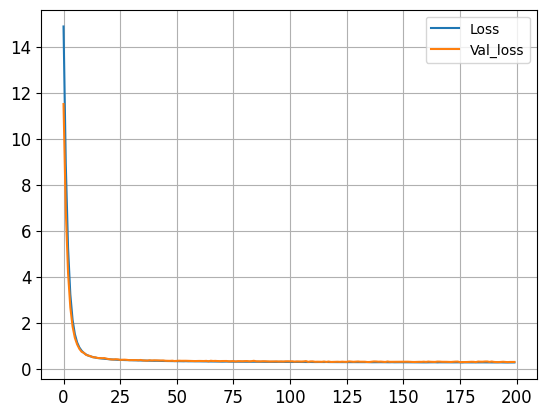

In [42]:
plt.plot(history.history["loss"],label="Loss")
plt.plot(history.history["val_loss"],label="Val_loss")
plt.grid(True)
#plt.xlim(0,20)
#plt.ylim(0,2)
plt.legend()
plt.show()

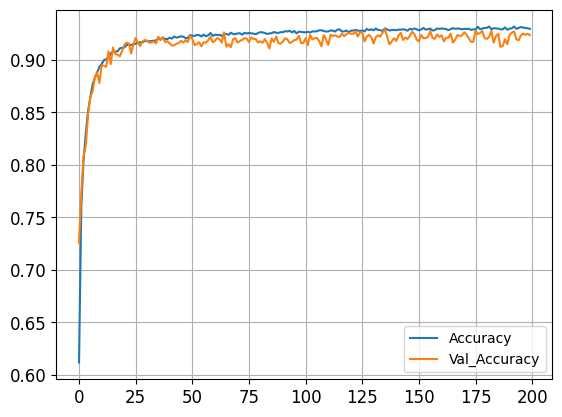

In [43]:
plt.plot(history.history["accuracy"],label="Accuracy")
plt.plot(history.history["val_accuracy"],label="Val_Accuracy")
plt.grid(True)
#plt.xlim(0,20)
#plt.ylim(0,0.05)
plt.legend()
plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


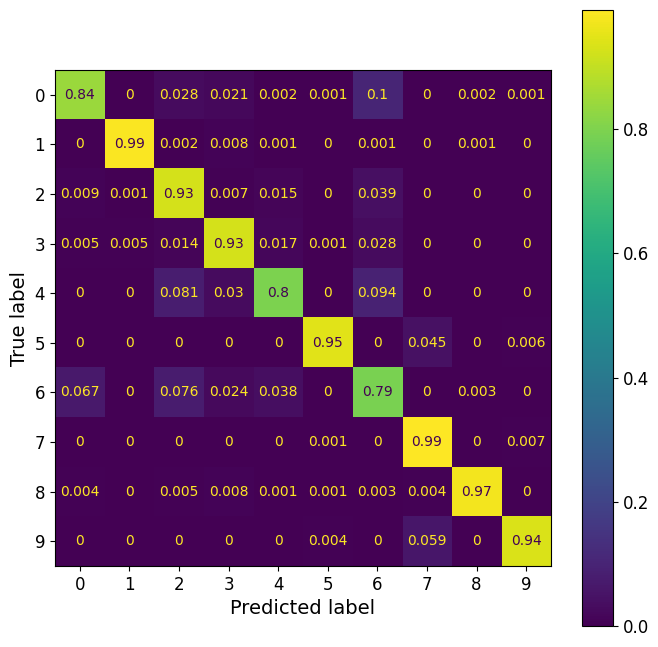

In [44]:
#Visualizamos la clasificación en predicción usando la matriz de confusion
show_classification(classifier)

**Implementación del GradCAM++**

**Pasos previos**

Creacion de variables y prueba

(28, 28)


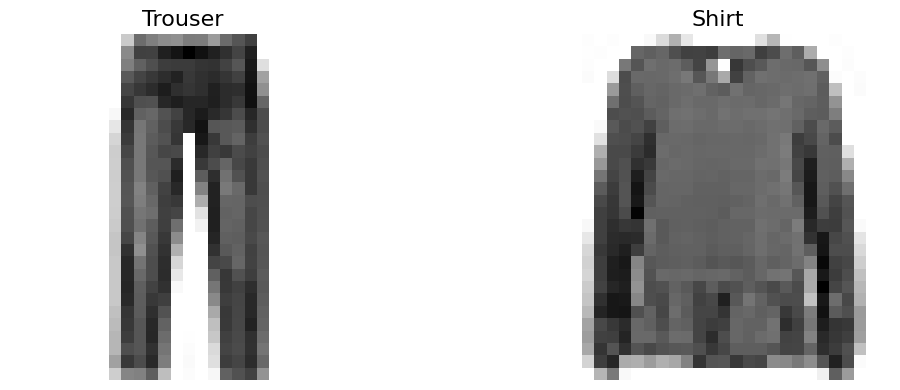

In [56]:
#Lo primero es definir las imagenes que se van a clasificar
#Les ponemos un título
img_titles=["Trouser","Shirt"]

#Dejo por acá porque es importante la lista con las clases y sus indices en fashion MNIST
classes=["T-shirt/top","Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag","Ankle boot"]

#Extraemos las imagenes que queremos clasificar
index_1 = None
for i, label in enumerate(y_train):
    if label == 1:  # Definimos el indice de la clase que queremos verificar, en este caso revisare la peor y mejor clasificada
        index_1 = i
        break

# y guardamos la imagen en una variable
if index_1 is not None:
    image_1 = X_train[index_1]

#Igual para la otra clase
index_2 = None
for i, label in enumerate(y_train):
    if label == 6:  # La otra clase que vamos a verificar
        index_2 = i
        break

# y guardamos la imagen en una variable
if index_2 is not None:
    image_2 = X_train[index_2]

#Las imagenes ya estaban normalizadas, pero por conveniencia mejor centrarlas en 0
image_1=np.array(image_1*2-1)

image_2=np.array(image_2*2-1)


#Creamos un arreglo de numpy con las imagenes
images = np.array([image_1,image_2])

# visualizamos las imagenes que vamos a utilizar
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
for i, title in enumerate(img_titles):
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i],cmap="binary")
    ax[i].axis('off')
plt.tight_layout()
plt.show()

**Definición del objeto GradCAM++**

**Otras funciones clave**

In [106]:
#Replace to linear se usa para cambiar la activacion de la capa que se vaya a visualizar a una linear que es 
#la que debe usarse para que los maps funcionen correctamente
replace2linear = ReplaceToLinear()

# Definimos el objeto gradcam
gradcam = GradcamPlusPlus(classifier,model_modifier=replace2linear,clone=True)

#Creamos una funcion que permita crear los heatmaps en secuencia para ver como las imagenes se relacionan con cada una de las diferentes clases
#y asi reutilizarla para ver los Cams en las 3 capas diferentes

def generate_cams(img_titles,classes,gradcam,images,conv_layer):
    lcam_ = []
    lcamN_= []
    for i in range(len(img_titles)):
        for j in range(len(classes)):
            score =  CategoricalScore(j)
            #Este paso es el que crea el objeto cam que luego se transforma en el heatmap
            cam = gradcam(score,
                  images[i],  normalize_cam = False,
                  penultimate_layer= conv_layer#Este es el parametro que define que capa vamos a visualizar
                           )
        # Guardamos los cams creados en una lista para mostarlos luego
            lcam_.append(cam[0])
        #similar pero los cams normalizados   
            lcamN_.append(normalize(cam[0])) 
    return lcam_ ,lcamN_

#Definimos la funcion para plotear las cams ya creadas
def plot_heatmaps(lcamN_,img_titles,classes,images,Sub_title):
    # Para visualizar las imagenes y el mapa de calor se crea un for que va a plotear
    # todas las imagenes generadas tanto del vestido como del bolso
    f, ax = plt.subplots(nrows=2, ncols=10, figsize=(22, 6))
    for i, title in enumerate(img_titles):
        for j in range(len(classes)):
            if i==0:
                heatmap = np.uint8(mpl.cm.jet(lcamN_[j])[..., :3] * 255)
                #heatmap = heatmap[0]
                ax[i][j].set_title(title + " vs "+ classes[j], fontsize=16)
                ax[i][j].imshow(images[i])
                ax[i][j].imshow(heatmap, cmap='jet', alpha=0.5)
                ax[i][j].axis('off')
            else:    
                heatmap = np.uint8(mpl.cm.jet(lcamN_[j+10])[..., :3] * 255)
                #heatmap = heatmap[0]
                ax[i][j].set_title(title + " vs "+classes[j], fontsize=16)
                ax[i][j].imshow(images[i])
                ax[i][j].imshow(heatmap, cmap='jet', alpha=0.5)
                ax[i][j].axis('off')
    plt.suptitle(Sub_title,fontsize=16)            
    plt.tight_layout()
    plt.show()

**Para la primera capa convolucional**

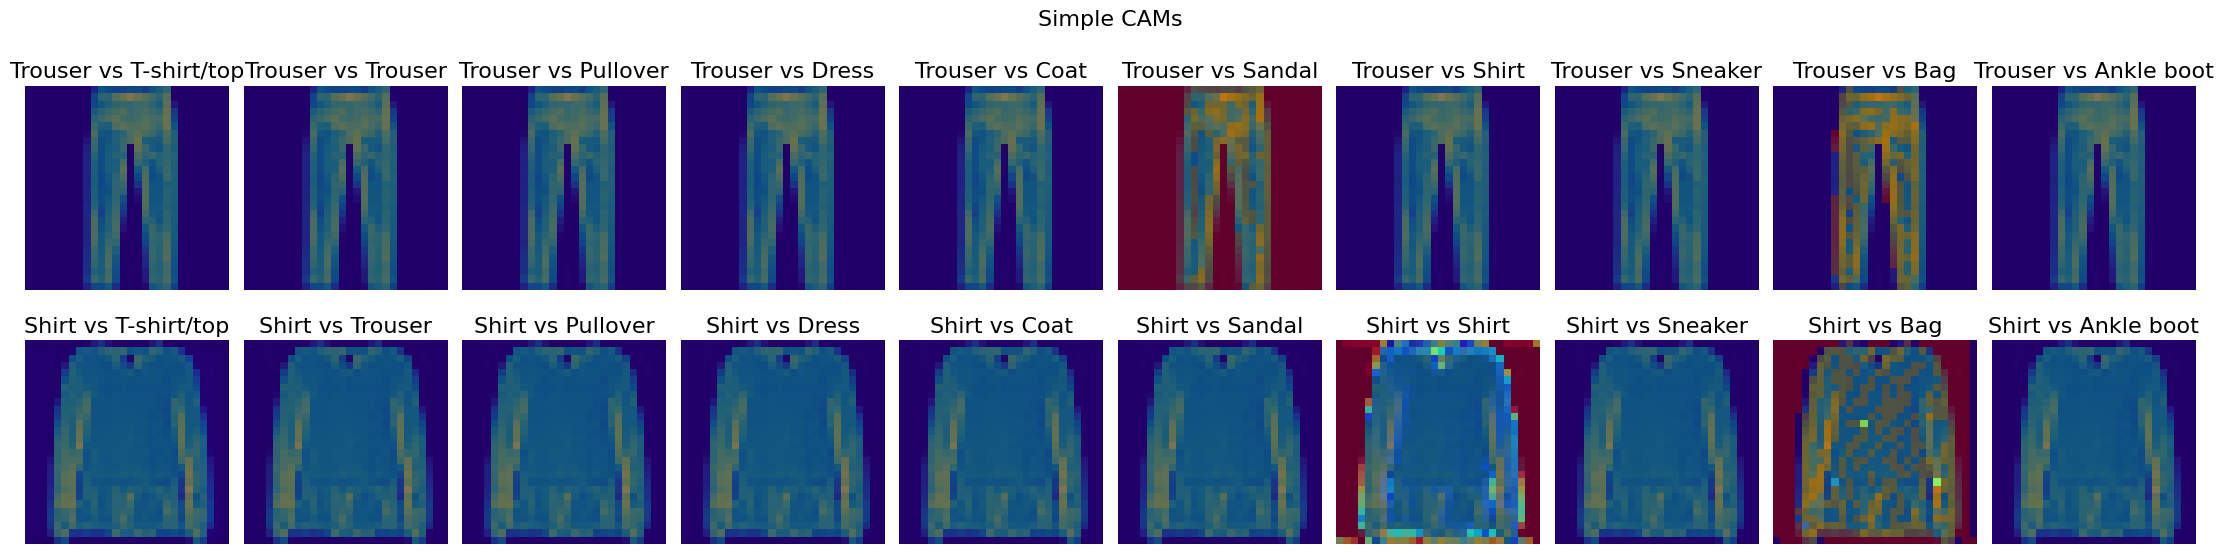

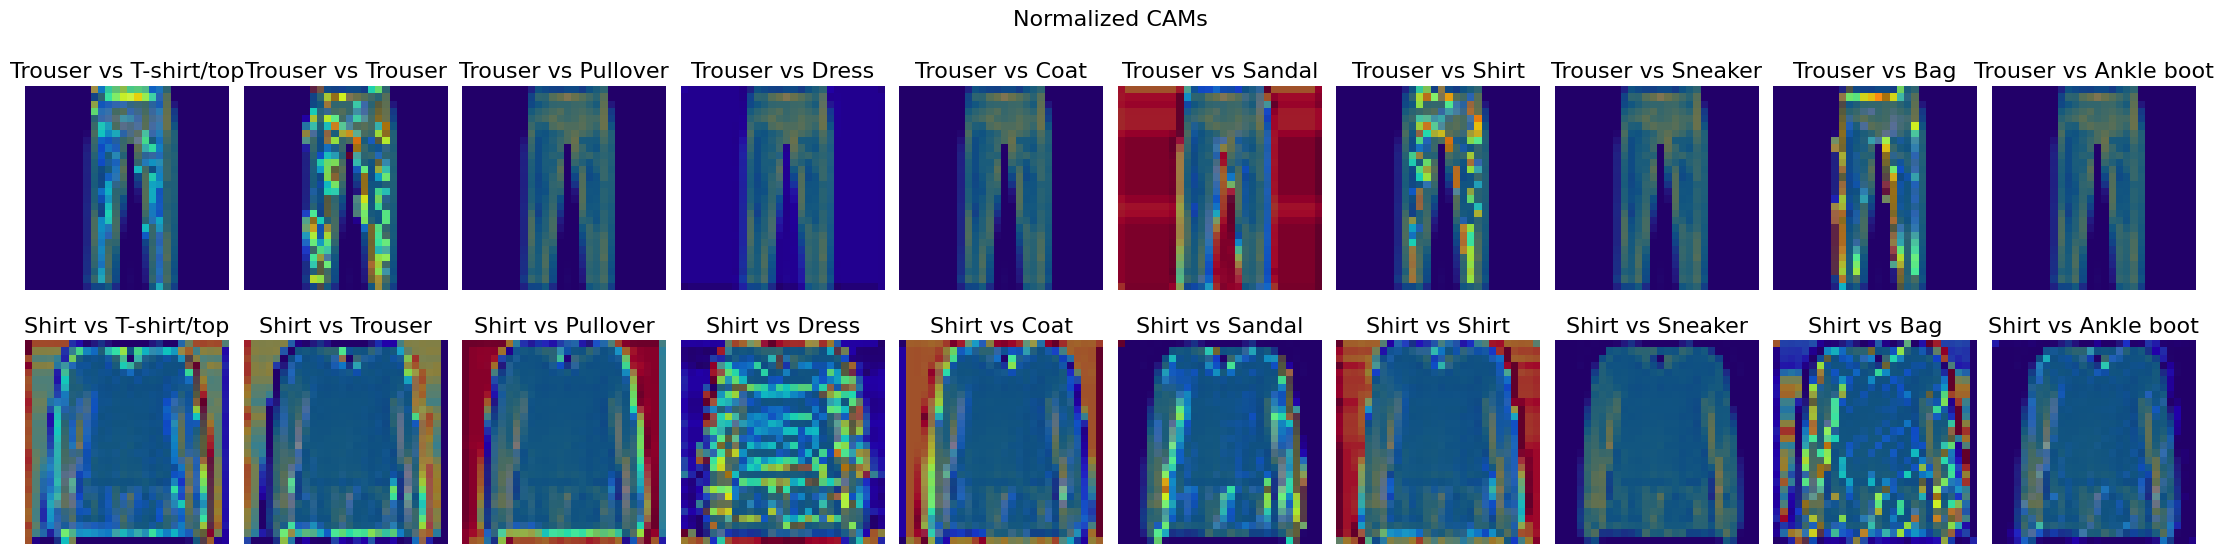

In [107]:
lcam_,lcamN_= generate_cams(img_titles,classes,gradcam,images,"Conv1")
plot_heatmaps(lcam_,img_titles,classes,images,"Simple CAMs")

plot_heatmaps(lcamN_,img_titles,classes,images,"Normalized CAMs")

**Para la segunda capa**

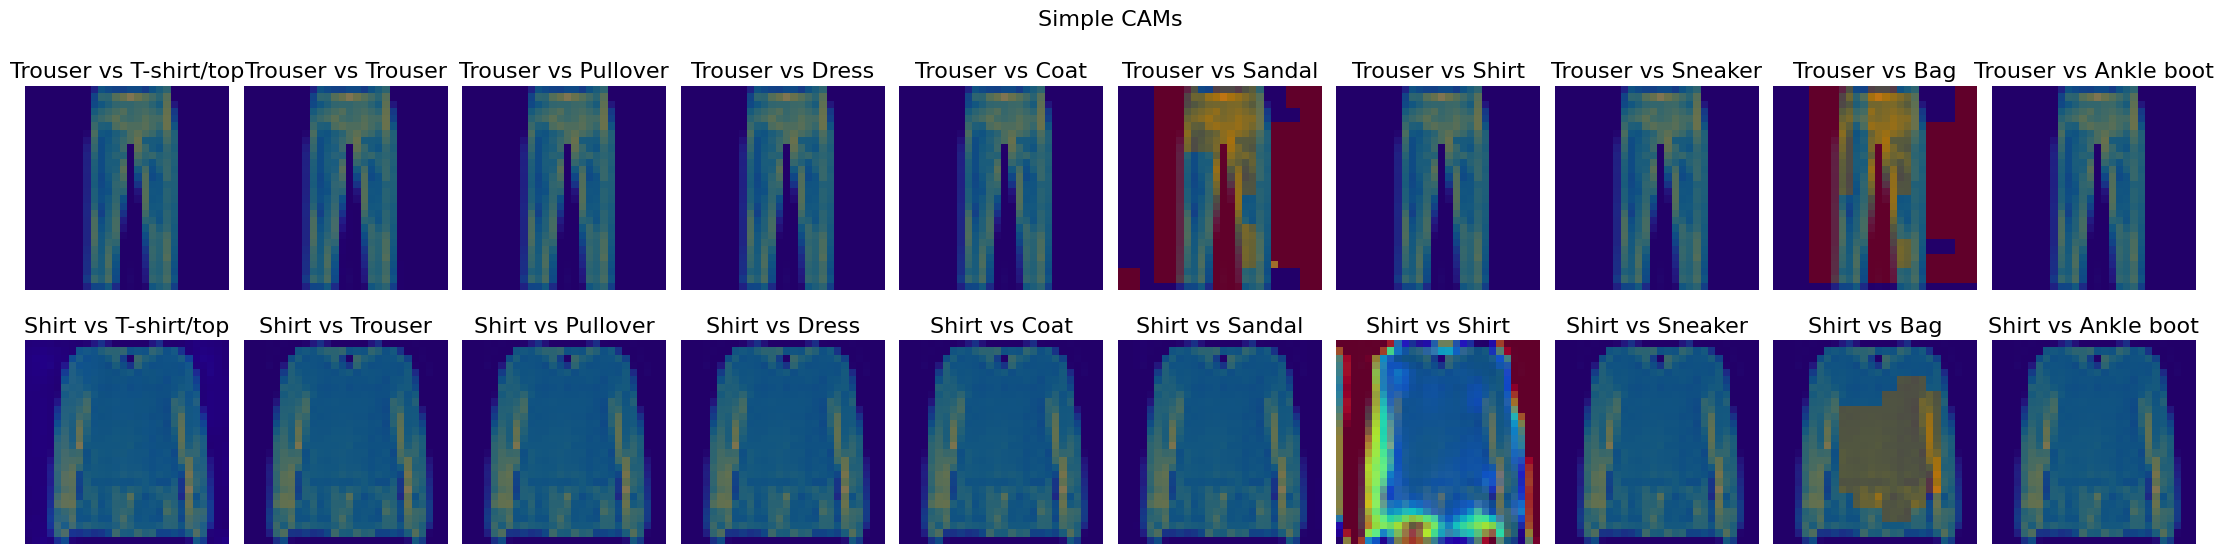

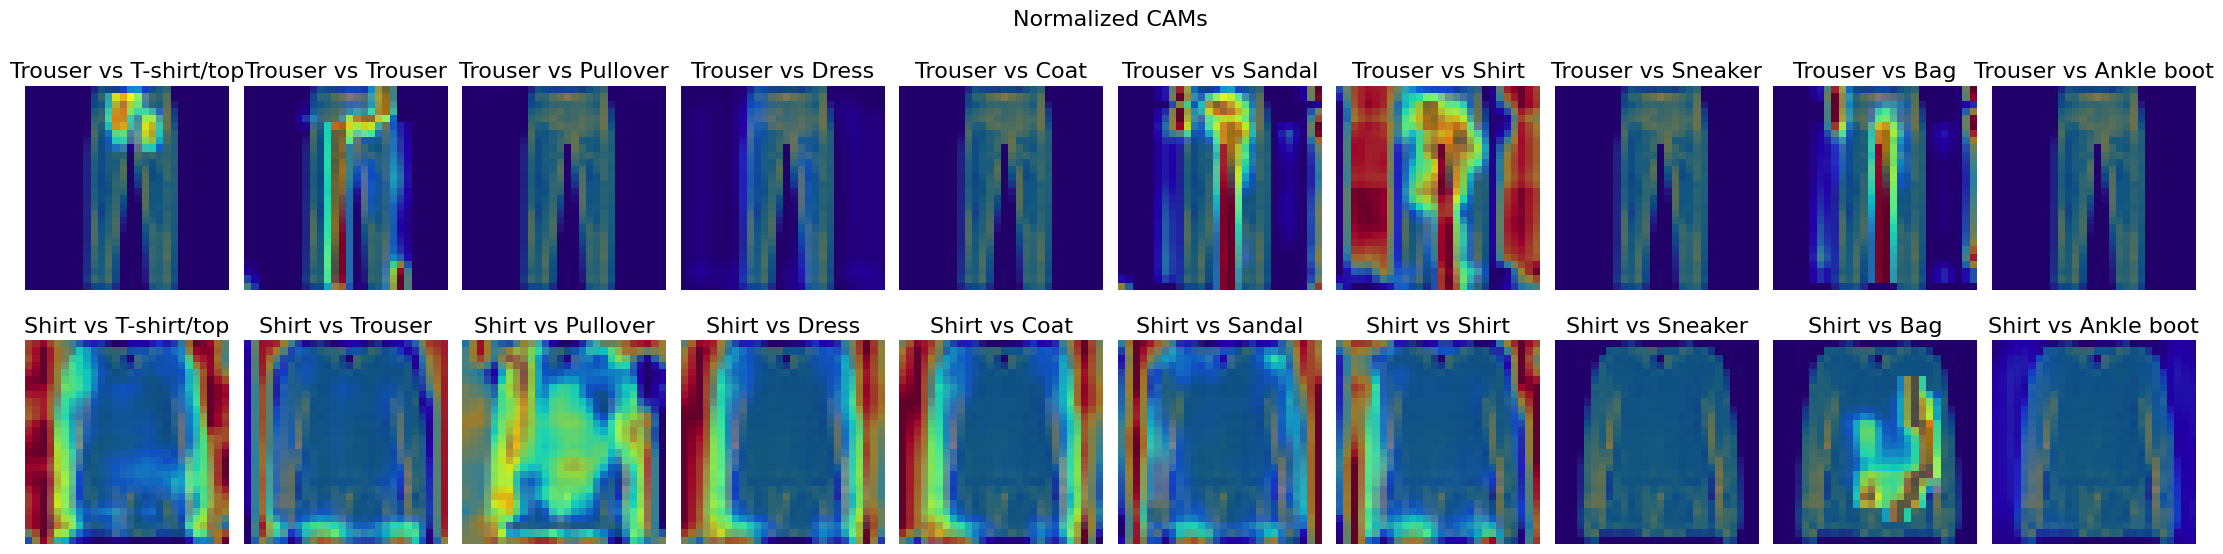

In [108]:
lcam_,lcamN_= generate_cams(img_titles,classes,gradcam,images,"Conv3")
plot_heatmaps(lcam_,img_titles,classes,images,"Simple CAMs")

plot_heatmaps(lcamN_,img_titles,classes,images,"Normalized CAMs")

**para la tercera capa**

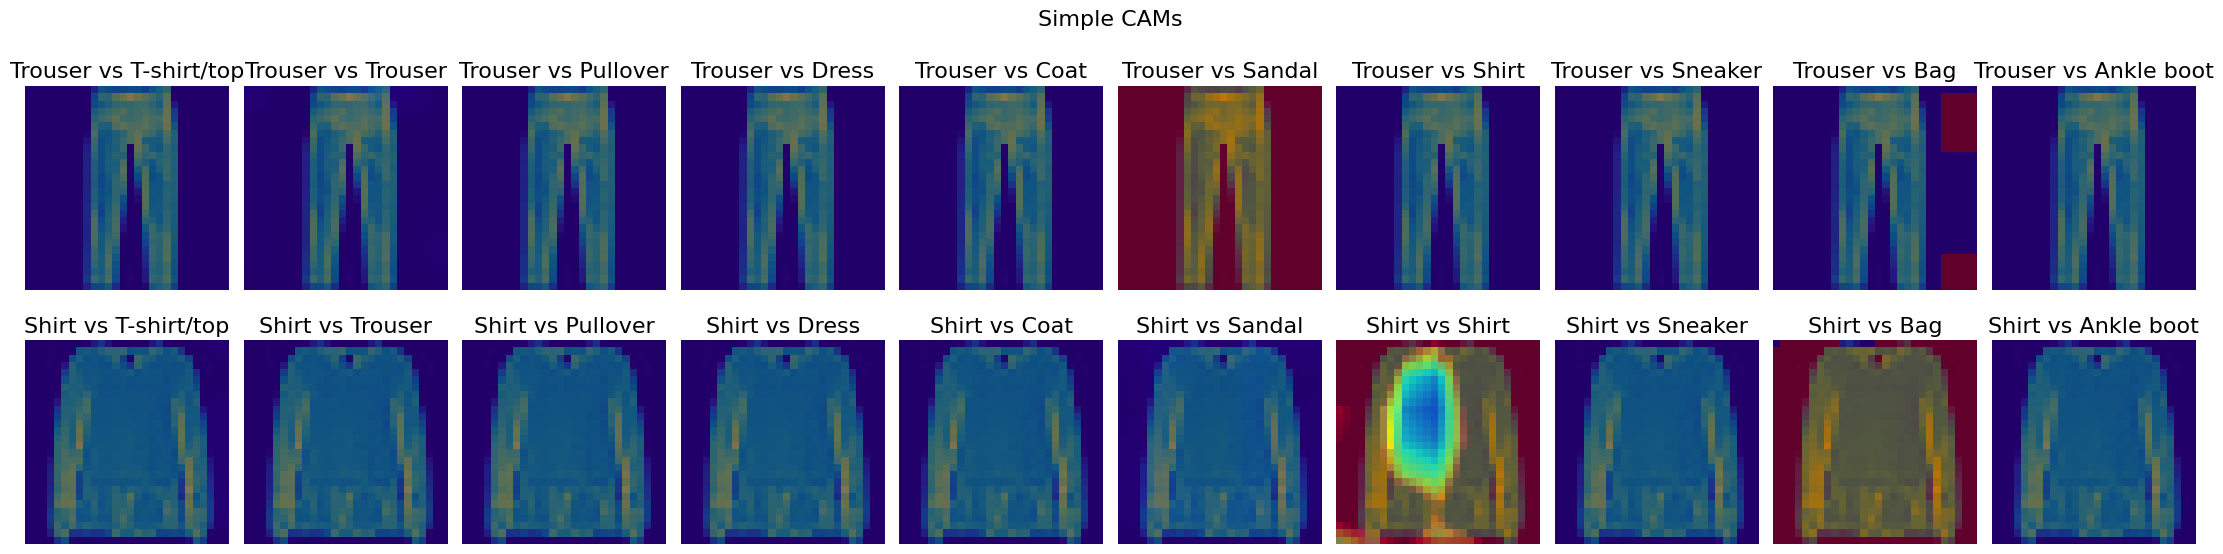

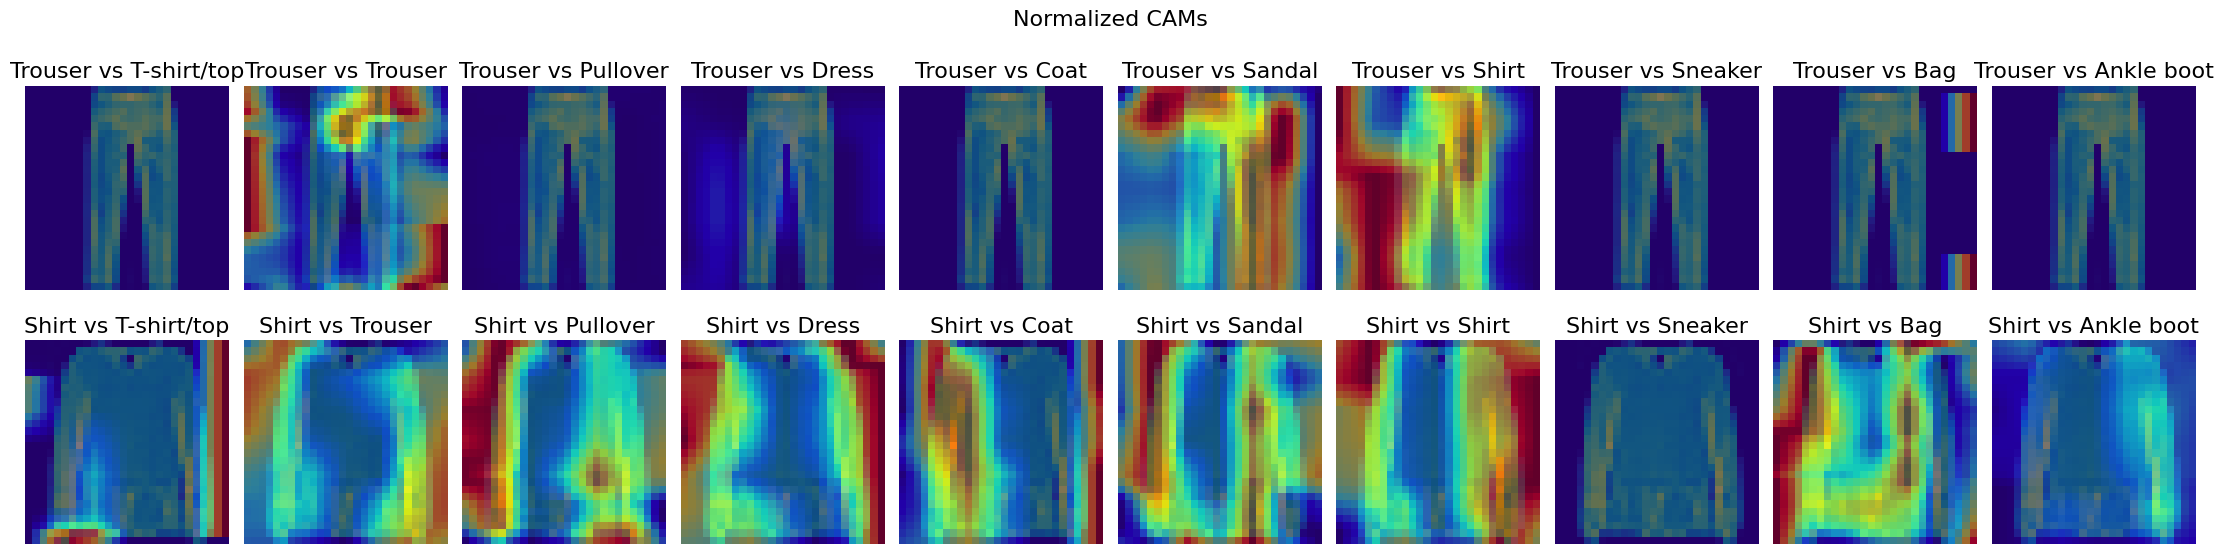

In [109]:
lcam_,lcamN_= generate_cams(img_titles,classes,gradcam,images,"Conv5")
plot_heatmaps(lcam_,img_titles,classes,images,"Simple CAMs")

plot_heatmaps(lcamN_,img_titles,classes,images,"Normalized CAMs")

## Seccion 2.4
**Deepfake**